In [208]:
import os
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import re
%matplotlib inline

First of all, we need to import our image data. The images in this dataset are contained within .pgm files, which are grayscale representations of the image. The files all have the same format which contains a header of the image shape, a maximum value, and then the raster data for the image. The function `read_pgm_to_array()` will allow us to read all the files in automatically and create numpy arrays out of them.

In [115]:
def read_pgm_to_array(path):
    try:
        with open(path) as f:
            lines = f.readlines()
    except FileNotFoundError:
        print('Cannot find the specified file')
        return False
    assert lines[0].strip() == 'P2' 

    raw = []
    for line in lines[1:]:
        raw.extend([int(c) for c in line.split()])
    
    im_shape = (raw[1], raw[0])
    max_val = raw[2]
    raster = np.array(raw[3:])
    return (raster, shape, max_val)

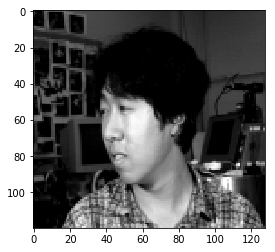

In [116]:
# let's pick a test image and see if it works
image, shape, _ = read_pgm_to_array('data/an2i/an2i_right_happy_open.pgm')
_ = imshow(np.reshape(image, shape), cmap = 'gray')

Now that we have confirmed our image processing & conversion is sound, we can automate the pull-in to loop over the available files (which are contained in directories for each person in the set) and split based on the labels which are contained within the file names. These point to the posture, emotion, and presence of eyewear within the picture which we can then use later to do some interesting things.

In [118]:
# automate the pulling in of images while using names of files as labels
data_dict = {"person":[], "posture":[], "emotion":[], "eyewear":[], "images":[], "shapes":[]}
people = os.listdir("data")
people = [p for p in people if '.' not in p]  # remove unwanted junk
for p in people:
    path = "data/" + p
    # load in images for each person
    files = os.listdir(path)
    files = [f for f in files if '.pgm' in f] # only want .pgm images
    for f in files:
        # ignore values that don't unpack into 5 items upon split
        # those are of different .pgm format than can handle
        try:  
            _, posture, emotion, eyewear, _ = re.split("_|\.", f)
            data_dict["person"].append(p)
            data_dict["posture"].append(posture)
            data_dict["emotion"].append(emotion)
            data_dict["eyewear"].append(eyewear)
            tmp_image, tmp_shape, _ = read_pgm_to_array(path + "/" + f)
            data_dict["images"].append(tmp_image)
            data_dict["shapes"].append(tmp_shape)
        except ValueError:
            pass

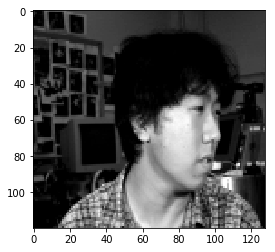

In [120]:
# how did it go?
_ = imshow(np.reshape(data_dict['images'][0], data_dict['shapes'][0]), cmap = 'gray')

In [231]:
# group together to make things easier going forward
import pandas as pd
df = pd.DataFrame(data_dict)
df.head()

,person,posture,emotion,eyewear,images,shapes
0,an2i,left,angry,open,"[21, 2, 1, 0, 2, 18, 59, 64, 56, 46, 46, 47, 4...","(120, 128)"
1,an2i,left,angry,sunglasses,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(120, 128)"
2,an2i,left,happy,open,"[21, 2, 0, 0, 2, 18, 60, 66, 58, 46, 47, 48, 5...","(120, 128)"
3,an2i,left,happy,sunglasses,"[22, 2, 1, 1, 3, 20, 63, 69, 60, 48, 49, 50, 5...","(120, 128)"
4,an2i,left,neutral,open,"[30, 67, 72, 66, 63, 61, 60, 61, 62, 63, 66, 7...","(120, 128)"


Images, given their size, are numerically represented in high-dimensional spaces. Even a 256 x 256 image, which is quite small, exists in a dimension we have no real intuition about. Dimensionality reduction allows us to project this high dimensional object to a lower dimension. The benefits are not just the ability (sometimes) to bring it closer to our lived reality, but also to reduce to the important components and, thus, preserve most of the information while saving space & the need for compute power. 

Rigorously, this means we want to find a linear transformation $\phi:\mathbb{R}^d\rightarrow\mathbb{R}^k$ where $k<<d$ that best preserves reconstruction accuracy. This, essentially, is minimizing the distance between a plane of $k$ dimensions in $d$ and the full representation in $\mathbb{R}^d$. 

This can be shown to be
$$
\arg_Q\min\frac{1}{n}\sum^n_{i=1}||\vec{x}_i-QQ^T\vec{x}_i||^2 = \arg_Q\max tr\left(Q^T\left(\frac{1}{n}XX^T\right)Q\right)
$$

where $Q$ is the projection matrix. So, for any projection to $k$ dimensions, this is the top $k$ eigenvectors of the covariance matrix $XX^T$. Note also, that
$$
tr\left(Q^T\left(\frac{1}{n}XX^T\right)Q\right)=\sum^k_{i=1}var\left(\vec{q}_i^Tx\right)
$$
which means inspecting the components will give us an insight about the variance of each and thus, give us an intuition of how much of the total variance is explained by a plane of $k$ dimensions.

In [149]:
from sklearn.decomposition import PCA
full_PCA = PCA()
_ = full_PCA.fit(data_dict['images'])

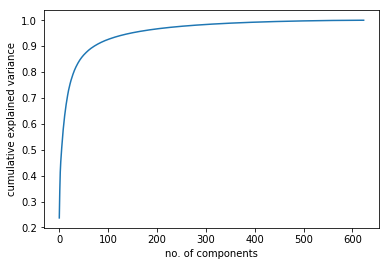

In [212]:
# plot the explained variance ratio
plt.plot(np.cumsum(full_PCA.explained_variance_ratio_))
plt.xlabel('no. of components')
_ = plt.ylabel('cumulative explained variance')

In [167]:
# fit the values for the happy & sad coded faces
happy_mask = df['emotion'] == 'happy'
sad_mask = df['emotion'] == 'sad'

happy_images, sad_images = [], []
idx = 0
for is_happy, is_sad in zip(happy_mask, sad_mask):
    if is_happy:
        happy_images.append(data_dict['images'][idx])
    if is_sad:
        sad_images.append(data_dict['images'][idx])
    idx += 1
    
happy_PCA, sad_PCA = PCA(), PCA()
happy_PCA.fit(happy_images)
_ = sad_PCA.fit(sad_images)

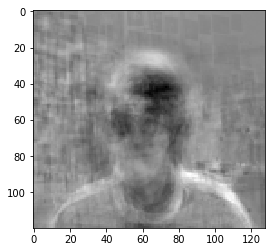

In [181]:
# show an average happy face
N_COMPS = 20
_ = imshow(np.average(happy_PCA.components_[:N_COMPS], axis=0).reshape(shape), cmap = 'gray')

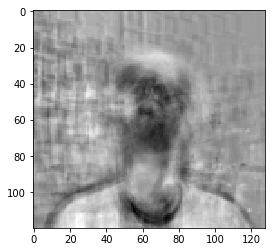

In [182]:
# and an average sad face
_ = imshow(np.average(sad_PCA.components_[:N_COMPS], axis=0).reshape(shape), cmap = 'gray')

Not much to be made of that, perhaps one could argue that sad face is a lot noisier, but it's a stretch. As mentioned, dimensionality reduction is useful for compression as we are concerned with reconstruction error. Let's take a particular example image and see if we can differentiate it in a lower dimension.

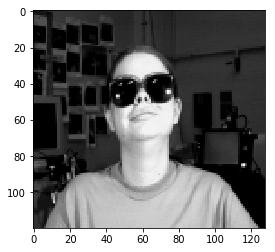

In [184]:
# show data compression of an image
test_image = data_dict['images'][155]
_ = imshow(test_image.reshape(shape), cmap = 'gray')

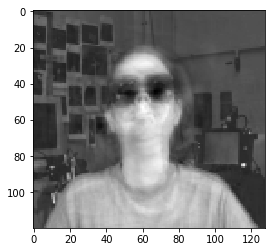

In [220]:
# what if we project that image down to a lower dimension, say k = 50?
DIM = 50
reconstruct_PCA = PCA(DIM).fit(data_dict['images'])
components = reconstruct_PCA.transform(test_image.reshape(1,-1))
projection = reconstruct_PCA.inverse_transform(components)
_ = imshow(projection.reshape(shape), cmap = 'gray')